# POL280 Bayesian Modeling Homework 2

### Gento Kato (May 25, 2017)

---

*Run a Bayesian linear model, assess convergence, and present results for a dataset of your choice.*

---

## 1. **Prepare Packages and Data**

In [1]:
## Clear Workspace
#rm(list=ls())
## Load Packages
library(rjags); library(mcmcplots); library(coefplot); library(ggplot2)
## Load Data
library(foreign)
GLOPE05 = read.dta("../data/POL280/gl0507_150710.dta")

Warning message:
"package 'rjags' was built under R version 3.3.3"Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs
Warning message:
"package 'mcmcplots' was built under R version 3.3.3"Loading required package: ggplot2


In [2]:
## Subset and Extract Data in Use
attach(GLOPE05)
subdt <- as.data.frame(cbind(bknowall,DKrate,
                             PAtohyox,PAtetsudaix,PAiraix,PAkoenx,PAtoinx,PAtoshienx,PAtegamix,PAyakushox,PAdemox,PAvolunteerx,PAjichikaix))
subdt <- na.omit(subdt)
detach(GLOPE05)
GLOPE05 = subdt
dim(GLOPE05)

[1] 1250   13

The <code>GLOPE05</code> data frame has 1250 rows and 13 columns. The observations are randomly sampled eligible voters in Japan, interviewed in 2005.

This data frame contains the following columns:
 * **bknowall**: Respondent's level of political knowledge. Combined score from multiple factual questions, ranges from 0 through 3.
 * **DKrate**: Respondent's rate of don't know answers to all ** *attitudinal* ** questions in the survey.
 * **PAtohyox**: Trichotomous variable of voting participation (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAtetsudaix**: Trichotomous variable of helping electoral campaign (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAiraix**: Trichotomous variable of asking others to vote (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAkoenx**: Trichotomous variable of joining candidate support group, koenkai  (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAtoinx**: Trichotomous variable of joining political party (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAtoshienx**: Trichotomous variable of contributing to political party (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAtegamix**: Trichotomous variable of sending letters to politicians (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAyakushox**: Trichotomous variable of visit government offices (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAdemox**: Trichotomous variable of participating demostration (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAvolunteerx**: Trichotomous variable of participating volunteers (2 = participate often, 1 = participate sometimes, 0 = never participate)
 * **PAjichikaix**: Trichotomous variable of participating residential association activities (2 = participate often, 1 = participate sometimes, 0 = never participate)


**Dependent Variable: Participation Level**

In what follows I create the summary variable of participation, and make it a dependent variable:

In [3]:
pcaPAdt <- prcomp(GLOPE05[,-c(1,2)]) ## Conduct PCA 
pcaPAdt$rotation[,1] ## Show loadings for the first component

PAtohyox  PAtetsudaix      PAiraix      PAkoenx      PAtoinx   PAtoshienx 
  -0.1362767   -0.3361728   -0.2867587   -0.2844158   -0.1700370   -0.2373375 
   PAtegamix   PAyakushox      PAdemox PAvolunteerx  PAjichikaix 
  -0.1974898   -0.3705640   -0.2293889   -0.4606494   -0.4229833

Since all the participation variables have negative loadings over the first component, I flip the sign of first component to create "Participation level" (=<code>PAlev</code>) variable.

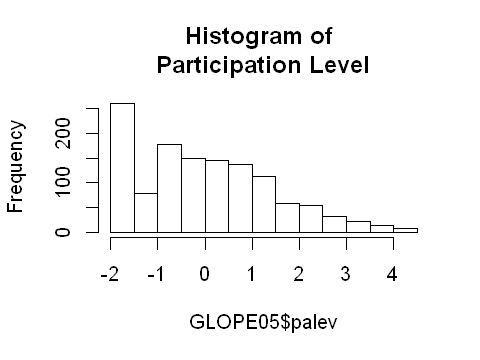

In [4]:
GLOPE05$palev = -pcaPAdt$x[,1]
options(repr.plot.width=4, repr.plot.height=3)
hist(GLOPE05$palev, main = "Histogram of \nParticipation Level")

**Independent Variables:**

Factual Political Knowledge Level (Standardize the original score to 0-1 range):

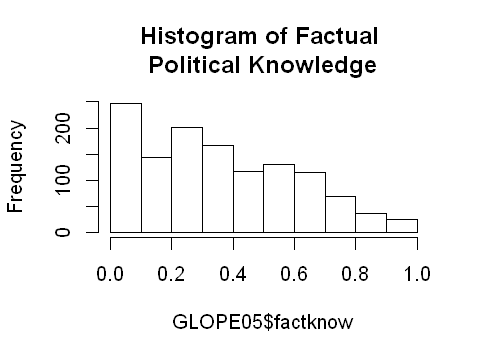

In [5]:
GLOPE05$factknow = GLOPE05$bknowall/3
options(repr.plot.width=4, repr.plot.height=3)
hist(GLOPE05$factknow, main = "Histogram of Factual \nPolitical Knowledge")

DK tendency (since the original distribution of DK rate is skewed, I use square root for the analysis): 


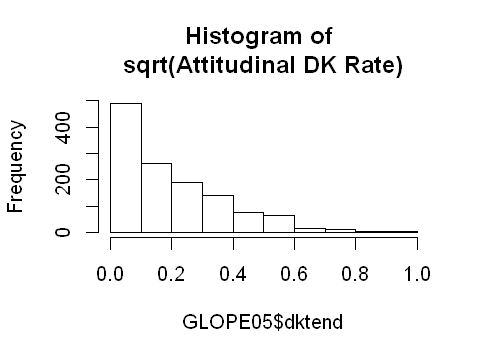

In [6]:
GLOPE05$dktend <- sqrt(GLOPE05$DKrate)
options(repr.plot.width=4, repr.plot.height=3)
hist(GLOPE05$dktend, main = "Histogram of \nsqrt(Attitudinal DK Rate)")

The genral expectations are:
 1. Higher Factual Knowledge $\Rightarrow$ More Participation.
 2. Larger Amount Don't Know towards Attitudinal Questions $\Rightarrow$ Less Participation.

## 2. **Run Frequentist Linear Regression**

Using <code>lm</code> model, and export coefficient plot:

Warning message:
"Ignoring unknown aesthetics: xmin, xmax"

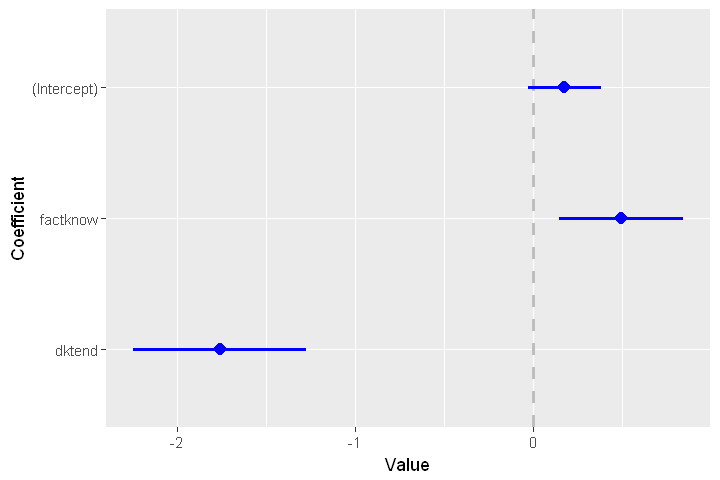

In [7]:
## OLS Prediction of Frequentist Model
ols <- lm(palev ~ factknow + dktend, data=GLOPE05)
#summary(ols) ## Predicting Morality by Heterogeneity and Mobility
options(repr.plot.width=6, repr.plot.height=4)
coefplot(ols, title = NULL, decreasing = TRUE, innerCI = 1.96, outerCI = 0)

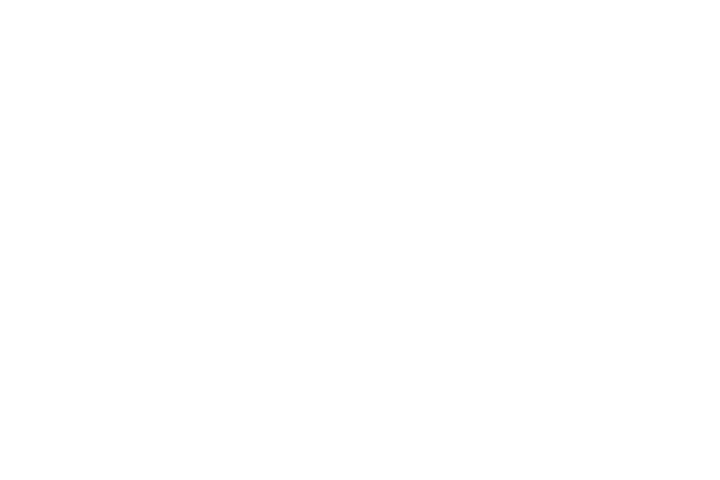

In [20]:
source("https://raw.githubusercontent.com/gentok/Method_Notes/master/sources/plot_coef.R")
source("https://raw.githubusercontent.com/gentok/Method_Notes/master/sources/gktheme.R")
plot_coef(ols)

In frequentist linear regression, the expectations are generally confirmed. More factually informed individuals have higher level of political participation, and respondents with higher don't know answer rate have lower level of political participation. 95% confidence interval for both variables do not cross zero, therefore, if these parameter values are zero in truth, there are less than 5% probability that this data is generated.

## 3. **Run Bayesian Linear Regression Model**

**JAGS code for Linear Regression**

VERY uninformative prior for coefficients (Uniform distribution in the range between -1000 and 1000)

In [182]:
glope.model <- "model{
for(i in 1:N){
palev[i] ~ dnorm(mu[i], tau)
mu[i] <- alpha + beta1 * factknow[i] + beta2 * dktend[i]
}
alpha ~ dunif(-1000, 1000)
beta1 ~ dunif(-1000, 1000)
beta2 ~ dunif(-1000, 1000)
tau ~ dgamma(.1, .1)
}"
## VERY uninformative priors of parameters.

**Prepare data for JAGS**

In [183]:
## Prepare Data
palev <- GLOPE05$palev ## DV
factknow <- GLOPE05$factknow ## IV 1
dktend <- GLOPE05$dktend ## IV 2
N <- length(palev) ## The sample size of data 

#Set of Parameters
glope.params <- c("alpha", "beta1", "beta2")

## Set Starting Values
glope.inits <- function(){
list("alpha" = rnorm(1,20,1), "beta1" = rnorm(1), "beta2" = rnorm(1))
}

**Execute Bayesian Linear Model**

In [184]:
glope.fit <- jags.model(textConnection(glope.model),
data = list(palev=palev, factknow=factknow, dktend=dktend, N=N),
inits = glope.inits, n.chains = 2, n.adapt = 10000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1250
   Unobserved stochastic nodes: 4
   Total graph size: 4436

Initializing model



In [185]:
samples <- coda.samples(glope.fit, glope.params, n.iter=5000, thin=5)
# thin: Just extracting every 5th observation in each iteration

In [186]:
head(samples) ## Check Inside

[[1]]
Markov Chain Monte Carlo (MCMC) output:
Start = 10005 
End = 10035 
Thinning interval = 5 
           alpha     beta1     beta2
[1,]  0.30216918 0.4552644 -2.092329
[2,]  0.25155394 0.5234288 -1.952976
[3,]  0.15809171 0.5911711 -1.814662
[4,]  0.17588875 0.5725553 -1.567344
[5,] -0.02222493 0.6834728 -1.196610
[6,]  0.11538278 0.5815896 -1.541068
[7,]  0.19148031 0.4390423 -1.847272

[[2]]
Markov Chain Monte Carlo (MCMC) output:
Start = 10005 
End = 10035 
Thinning interval = 5 
          alpha     beta1     beta2
[1,] 0.07296648 0.6468823 -1.613581
[2,] 0.03548988 0.7920375 -1.369281
[3,] 0.11180350 0.4539420 -1.653616
[4,] 0.04467803 0.6370735 -1.663023
[5,] 0.04969612 0.5929411 -1.574663
[6,] 0.11342372 0.5794432 -1.476459
[7,] 0.08750475 0.5702929 -1.539271

attr(,"class")
[1] "mcmc.list"

Rows represent extracted samples, columns represent parameters

In [187]:
summary(samples)


Iterations = 10005:15000
Thinning interval = 5 
Number of chains = 2 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD Naive SE Time-series SE
alpha  0.1763 0.09967 0.002229       0.004231
beta1  0.4859 0.17485 0.003910       0.006624
beta2 -1.7611 0.23745 0.005310       0.008176

2. Quantiles for each variable:

          2.5%     25%     50%     75%   97.5%
alpha -0.01732  0.1095  0.1738  0.2451  0.3756
beta1  0.16263  0.3626  0.4778  0.6021  0.8397
beta2 -2.22255 -1.9170 -1.7623 -1.5954 -1.2850


In [203]:
## Put results into the data frame
#all <- as.data.frame(do.call(rbind, samples))
#quantile(all$beta2, probs = c(0.025,0.975))

2.5%     97.5% 
-2.222553 -1.285044

Caterplot

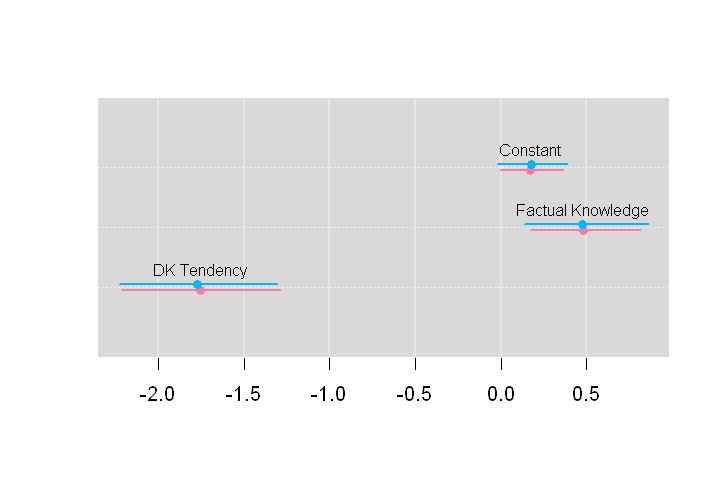

In [208]:
caterplot(samples, parms = c("alpha", "beta1", "beta2"), collapse = FALSE,
          labels = c( "Constant", "Factual Knowledge", "DK Tendency"), labels.loc = "above", 
          quantiles = list(inner=c(0.025,0.975)))

The result from catapillar plot shows two coefficients from each chains of estimation. The observation is almost identical to the ones from frequentist regression. For both factual knowledge and DK tendency, participation level changes in the expected direction, and credible intervals do not cross zero. However, now we can interpret the result more simply. Given that 95% credible intervals do not cross zero, there are less than 5% chance that the given parameter values are zero.

## 4. **Assess Bayesian Linear Regression Model**

**Plot Convergence Process**

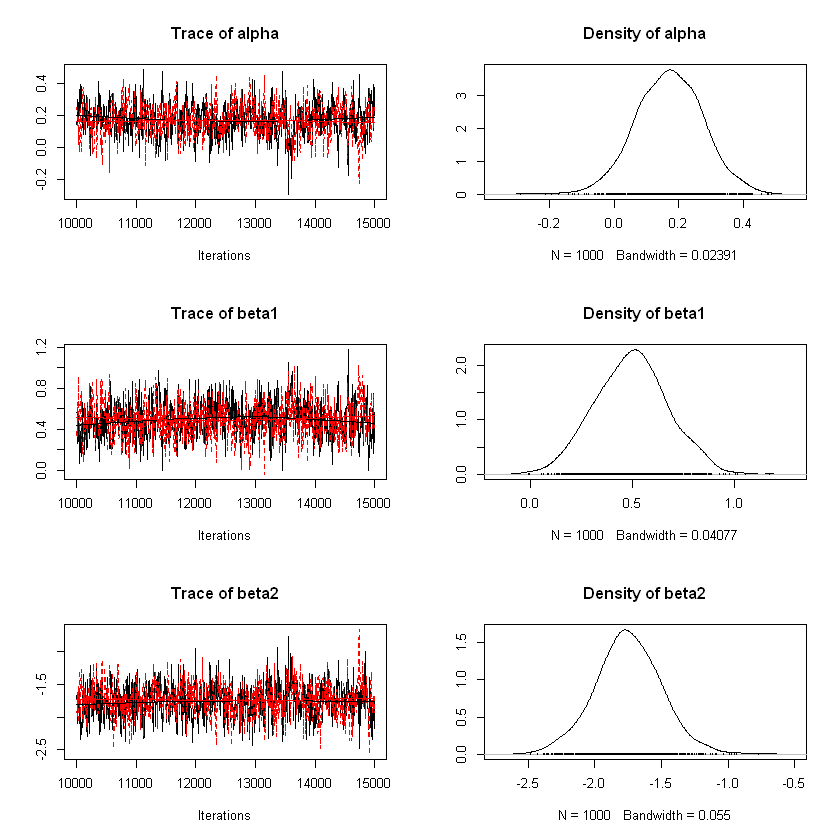

In [112]:
options(repr.plot.width=7, repr.plot.height=7)
plot(samples) 

The above trace and density plots indicate that the process converges quite well. From trace plots, estimated coefficient sizes stays almost constant for all of variables (including constant), and there is no sign of systematic deviation from the constant level. Also, there seems no sign of systematic difference between red and black chains of estimation. From density plots, it can be seen that estimated coefficients are distributed almost normally around their means.

**Check Auto Correlation**

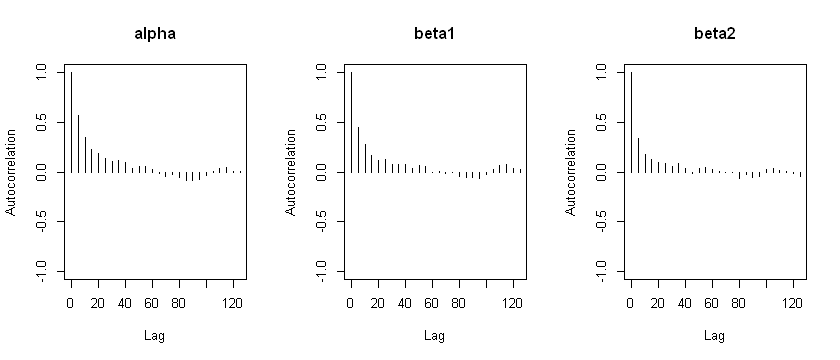

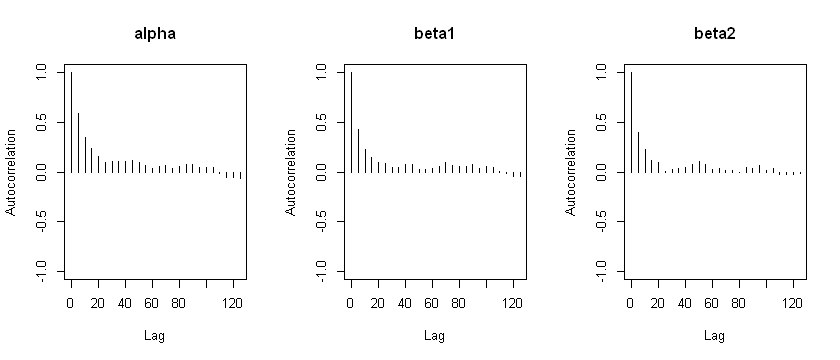

In [118]:
options(repr.plot.width=7, repr.plot.height=3)
par(mfrow=c(1,3))
autocorr.plot(samples, auto.layout = FALSE)

In the above auto-correlation plots, the level of autocorrelation declines as the size of lag increases. This confirms the expectation.

**Geweke Diagnostics**

In [119]:
geweke.diag(samples)

[[1]]

Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

 alpha  beta1  beta2 
 1.842 -2.338 -1.962 


[[2]]

Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

 alpha  beta1  beta2 
-1.800  1.438  1.676 



The values from Geweke diagnostics are t-values. From the output, it can be seen that alpha values in both chains converges well, in that the difference between last 50% and last 10% of simulations is not statistically significant ($< 1.96$). In the second chain, the Geweke diagnostic shows sign of convergence ($<1.96$) for two other parameters. On the other hand, for the first chain, the Geweke diagnostics for both beta 1 and beta 2 slightly exceed 1.96. This implies that the estimated coefficient may not be reaching the stable state. More iteration may be needed to make sure that the coefficients converge well.

**Gelman-Rubin Diagnostic Plot**

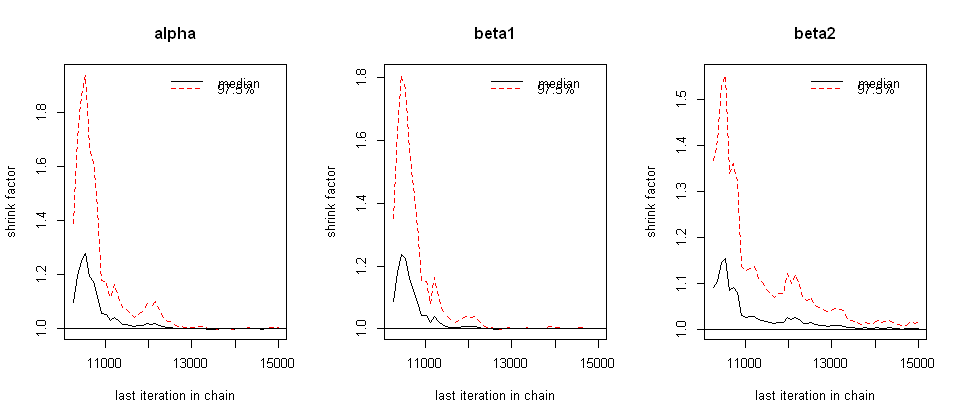

In [129]:
options(repr.plot.width=8, repr.plot.height=3.5)
par(mfrow=c(1,3))
gelman.plot(samples, auto.layout = FALSE)

The above plot shows that the shrink factor goes below the poiint 1.1 after some points between 12000 and 13000 iterations, and stays below that points. It indicates that the difference in variance of two chains get sufficiently small in those interation stages, and we can be quite confident to say that the estimation is converged. 